In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.stattools import acf
from pandas.plotting import lag_plot
from pylab import rcParams

In [2]:
#Settings
#Plot Settings
sns.set()
plt.style.use('ggplot')
%matplotlib inline
rcParams['figure.figsize'] = 12, 8
rcParams["figure.titlesize"] = 15
rcParams['font.size'] = 15
palette = sns.color_palette(["#4286f4","#f44141"])
#Simulation Settings
# Number of periods to be simulated
n_bootstrap = 10000

In [3]:
# url containing the dataset
url = 'https://bolin.su.se/data/stockholm/files/stockholm-historical-weather-observations-2017/' \
      'temperature/daily/stockholm_daily_mean_temperature_1756_2017.txt'
column_names = ['Year','Month','Day','Temperature_Raw','Temperature_Processed_1',
                'Temperature_Processed_2','Data_ID']
# Reading the Data
temperatures_raw = pd.read_csv(url,sep ='\s+',names = column_names)

In [4]:
temperatures_raw.head()

,Year,Month,Day,Temperature_Raw,Temperature_Processed_1,Temperature_Processed_2,Data_ID
0,1756,1,1,-8.7,-8.7,-8.7,1
1,1756,1,2,-9.2,-9.2,-9.2,1
2,1756,1,3,-8.6,-8.6,-8.6,1
3,1756,1,4,-7.7,-7.7,-7.7,1
4,1756,1,5,-7.2,-7.2,-7.2,1


In [5]:
#Calculate the Mean Temperature for Each Year
temperatures_yearly = temperatures_raw.groupby(['Year'])['Temperature_Processed_2'].mean().reset_index()
# Rename the Columns
temperatures_yearly.columns = ['Year','Average_Temperature']
# Get the century number for each year
temperatures_yearly['Century'] = (temperatures_yearly['Year'].apply(lambda x: x // 100 + 1 )).astype('int32')
# Get a categorical feature indicating whether the year is before or after 1950
temperatures_yearly['Time-Era'] = temperatures_yearly['Year'].apply(lambda x: 'Before 50s' if x < 1950  else 'After 50s')
temperatures_yearly.columns = ['Year','Average_Temperature','Century','Time-Era']
# Sanity Checks
assert temperatures_yearly.shape[0] == 262, "Check the Number of Years (262)"
assert temperatures_yearly['Time-Era'].nunique() == 2,"Check the lambda function Time -Era"
temperatures_yearly.sample(10)

,Year,Average_Temperature,Century,Time-Era
26,1782,4.750959,18,Before 50s
167,1923,4.840000,20,Before 50s
241,1997,7.018356,20,After 50s
90,1846,6.412603,19,Before 50s
213,1969,5.718904,20,After 50s
52,1808,5.277869,19,Before 50s
236,1992,7.212295,20,After 50s
215,1971,6.161370,20,After 50s
88,1844,4.009290,19,Before 50s
48,1804,4.674863,19,Before 50s


In [7]:
temperatures_yearly.sort_values('Average_Temperature',ascending=False).head(10)

,Year,Average_Temperature,Century,Time-Era
258,2014,8.060274,21,After 50s
259,2015,7.955616,21,After 50s
178,1934,7.808219,20,Before 50s
255,2011,7.770137,21,After 50s
252,2008,7.763661,21,After 50s
23,1779,7.734247,18,Before 50s
244,2000,7.728415,21,After 50s
250,2006,7.718904,21,After 50s
233,1989,7.711781,20,After 50s
219,1975,7.710685,20,After 50s


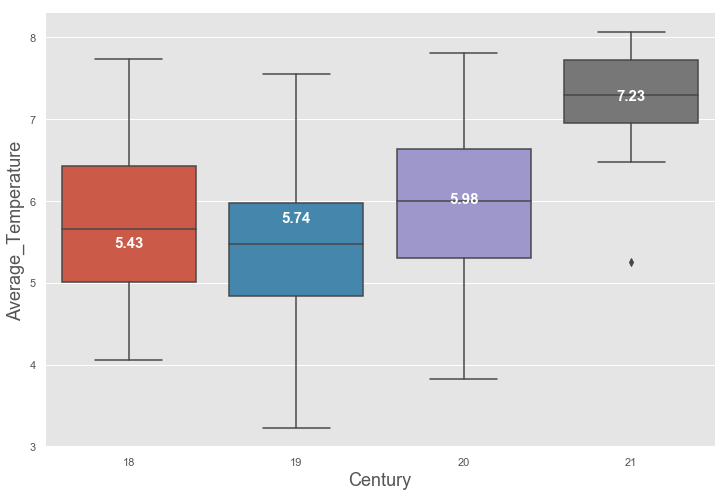

In [20]:
ax = sns.boxplot(x = 'Century', y = 'Average_Temperature', data = temperatures_yearly)
medians = temperatures_yearly.groupby('Century')['Average_Temperature'].mean().sort_values(ascending = True).values
median_labels = [str(np.round(s,2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 
            medians[tick], 
            median_labels[tick], 
            horizontalalignment='center', 
            size='medium', 
            color='w', 
            weight='semibold')

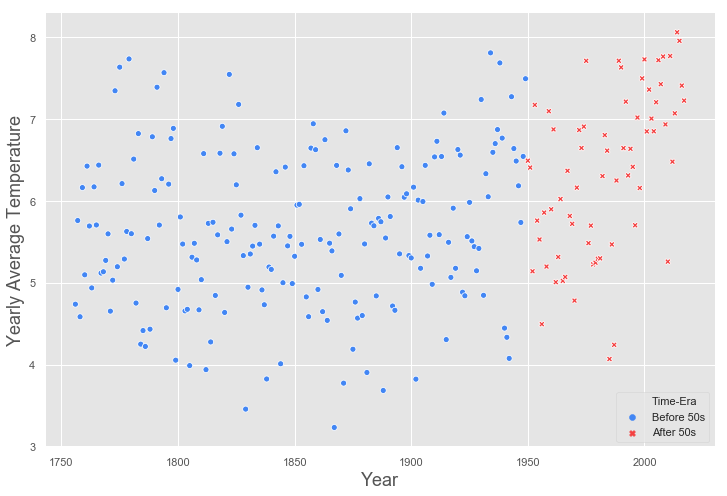

In [7]:
ax = sns.scatterplot(x = 'Year',y = 'Average_Temperature', 
                     hue = 'Time-Era', 
                     style="Time-Era", 
                     palette = palette,
                     data = temperatures_yearly)
ax.set_ylabel('Yearly Average Temperature')
ax.legend(loc='lower right');

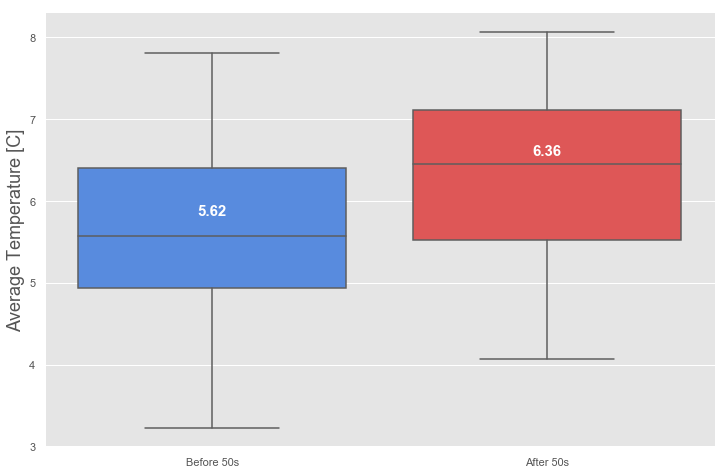

In [22]:
ax = sns.boxplot(x = 'Time-Era', y = 'Average_Temperature',palette = palette, data = temperatures_yearly)
ax.set_ylabel('Average Temperature [C]')
ax.set_xlabel('')
medians = temperatures_yearly.groupby('Time-Era')['Average_Temperature'].mean().sort_values(ascending = True).values
median_labels = [str(np.round(s,2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 
            medians[tick] + 0.2, 
            median_labels[tick], 
            horizontalalignment='center', 
            size='medium', 
            color='w', 
            weight='semibold')

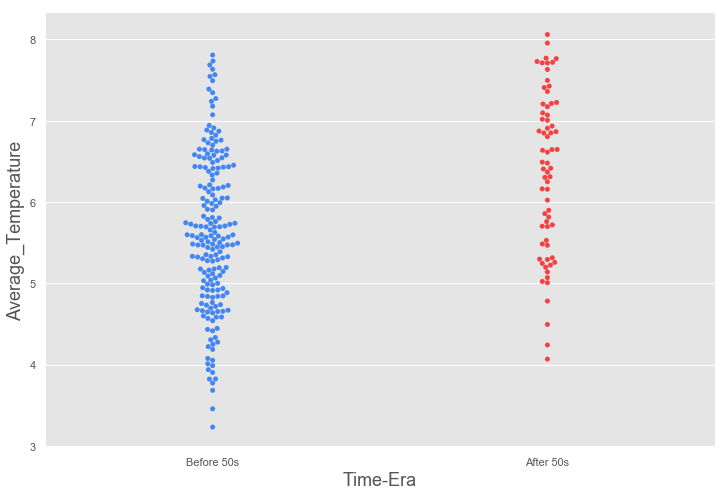

In [9]:
sns.swarmplot(x = temperatures_yearly['Time-Era'], y = temperatures_yearly['Average_Temperature'], 
              palette = palette);

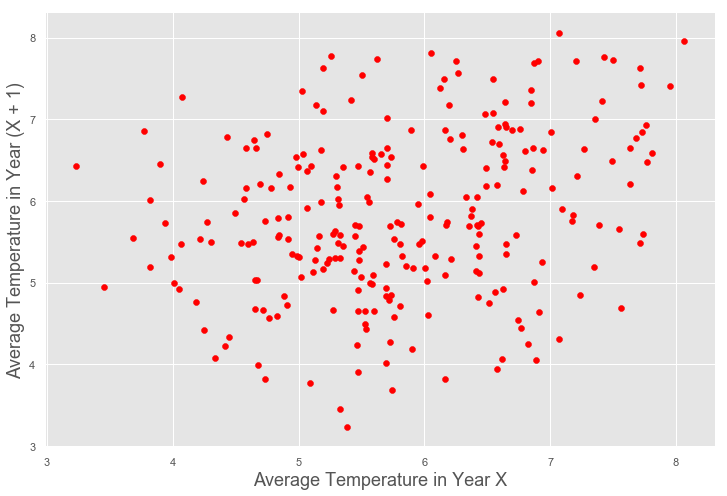

In [10]:
ax = lag_plot(temperatures_yearly['Average_Temperature'], c = 'red')
ax.set_xlabel('Average Temperature in Year X')
ax.set_ylabel('Average Temperature in Year (X + 1)');

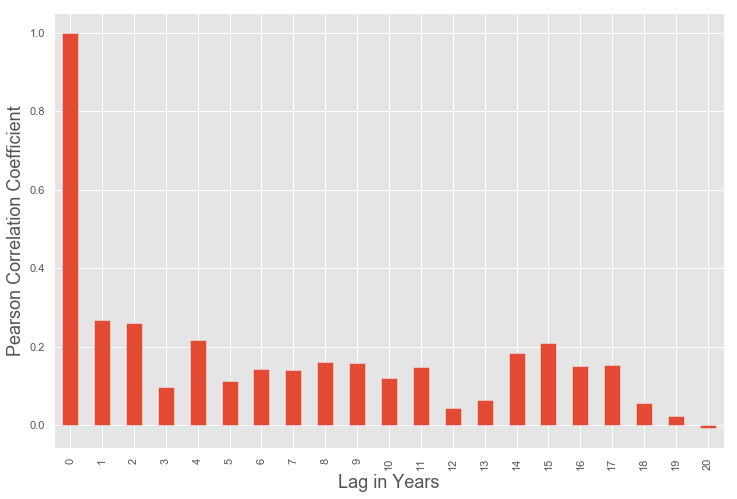

In [11]:
pd.DataFrame(acf(temperatures_yearly['Average_Temperature'],nlags = 20)).plot(kind= 'bar',legend = False)
plt.xlabel('Lag in Years')
plt.ylabel('Pearson Correlation Coefficient');

In [12]:
before_50s = temperatures_yearly[temperatures_yearly['Time-Era'] == 'Before 50s']['Average_Temperature']
after_50s = temperatures_yearly[temperatures_yearly['Time-Era'] == 'After 50s']['Average_Temperature']

In [13]:
def permutation_iid_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    
        # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    permuted_sample_1 = permuted_data[:len(data1)]
    permuted_sample_2 = permuted_data[len(data1):]

    return permuted_sample_1, permuted_sample_2

In [14]:
def permutation_replicates(data_1, data_2, function_to_apply, size=1):
    """Generate multiple permutation replicates."""
    

    # Initialize and empty array of replicates
    permuted_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_iid_sample(data_1, data_2)

        # Compute the test statistic
        permuted_replicates[i] = function_to_apply(perm_sample_1, perm_sample_2)

    return permuted_replicates

In [15]:
def means_diff(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [24]:
np.random.seed(13)
empirical_diff = round((np.mean(after_50s) - np.mean(before_50s)),2)
replicates = permutation_replicates(after_50s,before_50s,means_diff,size = n_bootstrap)
p = np.sum(replicates >= empirical_diff ) / len(replicates)
f"The p-value for the test-statistic of {empirical_diff:.2f} is {p:.3f}"

'The p-value for the test-statistic of 0.73 is 0.000'

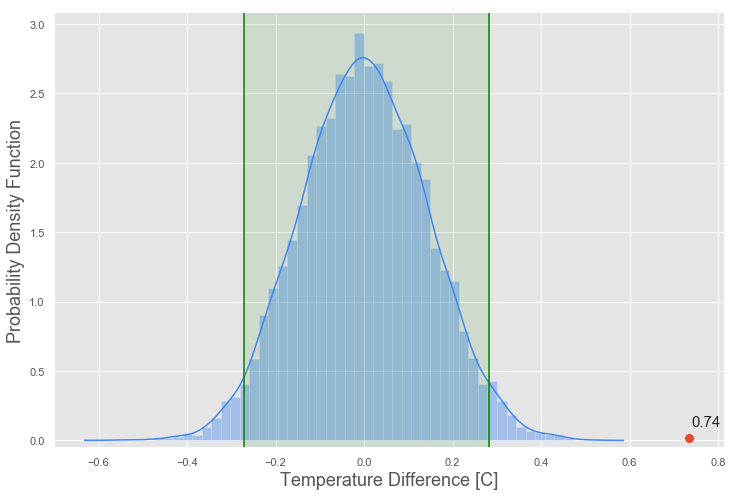

In [25]:
ax = sns.distplot(replicates, color = palette[0])
confidence_interval = np.percentile(replicates,[2.5,97.5])
ax.axvline(confidence_interval[0],color = 'green')
ax.axvline(confidence_interval[1],color = 'green')
ax.axvspan(confidence_interval[0],confidence_interval[1],color = 'green', alpha = 0.1)
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Temperature Difference [C]')
ax1 = sns.scatterplot(x = np.array([empirical_diff]),y = 0.020, s = 100)
ax.set_ylim(-0.05)
ax.annotate(str(empirical_diff),xy = (empirical_diff,0.1));

'The p-value for the test-statistic of 0.73 is 0.000'

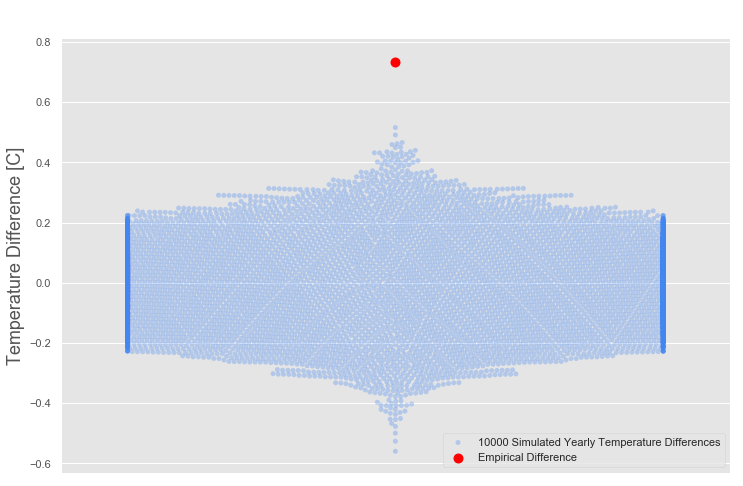

In [19]:
ax = sns.swarmplot(y = replicates,alpha = 0.30,palette = palette, 
                   label = (str(n_bootstrap) + ' Simulated Yearly Temperature Differences'))
ax = sns.swarmplot(y = np.array([empirical_diff]), color = 'red', size = 10, label = 'Empirical Difference' )
ax.legend(loc = 'lower right')
ax.set_ylabel('Temperature Difference [C]')
ax.annotate('0.88',xy = (0.015,0.88));